<a href="https://colab.research.google.com/github/sunny0103/DeepLearning_nlp_projects/blob/main/%20DeepLearning_nlp_projects/Naver_shopping_reviews_version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/Data/shopping_reviews"

/content/drive/MyDrive/Data/shopping_reviews


In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

from tqdm import tqdm, tqdm_notebook
# from glob import glob

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [4]:
df = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
display(df.head())
display(test.head())

,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


,id,reviews
0,0,채소가 약간 시들어 있어요
1,1,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리...
2,2,부들부들 좋네요 입어보고 시원하면 또 살게요
3,3,이런 1. 8 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임?
4,4,검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별하나도 아까워요


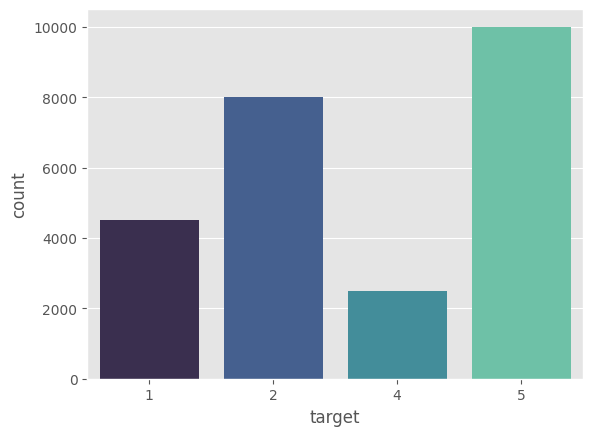

In [5]:
sns.countplot(df, x='target', palette ='mako')
plt.show()

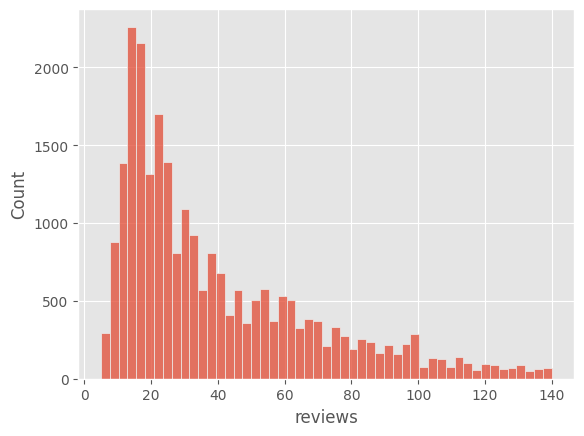

In [6]:
sns.histplot(df['reviews'].str.len())
plt.show()

In [7]:
!pip install emoji==0.6.0 # 이모티콘
!pip install soynlp==0.0.493  #신조어 및 반복문장 정규화

In [8]:
from soynlp.normalizer import repeat_normalize
import re
import emoji

In [9]:
emojis = ''.join(emoji.UNICODE_EMOJI.keys())
pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣{emojis}]+')
url_pattern = re.compile(
    r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

In [10]:
def cleaning_data(x):
  x = pattern.sub('', x)
  x = url_pattern.sub('',x)
  x = x.strip()
  x = repeat_normalize(x,num_repeats=2)
  return x

In [11]:
import copy
cleaned_train = copy.deepcopy(df)
cleaned_test = copy.deepcopy(test)

In [12]:
cleaned_train

,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5
...,...,...,...
24995,24995,일단향이너무너무좋은데지속력만좋다면좋겠지만..워낙저렴해그래도좋아여,5
24996,24996,동일한 업체에서 발송하고 한 상자로 배송되었는데 택배비는 이중 처리되었습니다.,2
24997,24997,향이 좋아요!! 다른 향도 시켜보고 싶어요,4
24998,24998,펼쳐보니 끝부분쯤에 50cm정도 찟어져 있습니다 날짜관계로 구냥 사용합니다,2


In [13]:
cleaned_train.to_csv('./cleaned_train.csv', index=False)
cleaned_test.to_csv('./cleaned_test.csv', index=False)

In [14]:
!pip install transformers[torch] datasets

In [15]:
!pip install accelerate -U

In [16]:
from datasets import (load_dataset,
                      DatasetDict)

from transformers import (AutoTokenizer,
                          AdamW,
                          AutoModelForSequenceClassification
                          )

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn

from sklearn.metrics import accuracy_score

import random
import os
from tqdm import tqdm, tqdm_notebook

In [17]:
def seed_everything(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)

seed_everything(42)
SEED = 42

In [18]:
df=pd.read_csv('./cleaned_train.csv')
df.head()
df.shape

(25000, 3)

In [19]:
df.drop('id',axis=1, inplace= True)
df.head()

,reviews,target
0,조아요 처음구입 싸게햇어요,2
1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,튼튼하고 손목을 잘 받쳐주네요~,5


In [20]:
targets = sorted(df.target.unique())

label_dict = {}
for idx, label in enumerate(targets):
  label_dict[label] = idx
label_dict

{1: 0, 2: 1, 4: 2, 5: 3}

In [21]:
df['label'] = df.target.replace(label_dict)

In [22]:
df.head()

,reviews,target,label
0,조아요 처음구입 싸게햇어요,2,1
1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1,0
2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2,1
3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2,1
4,튼튼하고 손목을 잘 받쳐주네요~,5,3


In [23]:
from sklearn.model_selection import train_test_split
# index로 train, validation을 나눔
# imbalaced label => stratify label
X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df.label.values,
                                                  test_size=0.2,
                                                  random_state=SEED,
                                                  stratify=df.label.values)

In [24]:
df['data_type'] = ['not_set'] * df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'valid'

In [25]:
df.groupby(['label', 'data_type']).count()

reviews  target
label data_type                 
0     train         3600    3600
      valid          900     900
1     train         6400    6400
      valid         1600    1600
2     train         2000    2000
      valid          500     500
3     train         8000    8000
      valid         2000    2000

In [26]:
df.head()

,reviews,target,label,data_type
0,조아요 처음구입 싸게햇어요,2,1,train
1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1,0,train
2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2,1,train
3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2,1,valid
4,튼튼하고 손목을 잘 받쳐주네요~,5,3,train


In [27]:
# # total dataset
# train_set = df[df.data_type =='train']
# valid_set = df[df.data_type =='valid']

In [28]:
# sample dataset
train_set = df[df.data_type =='train'].sample(n=2000)
valid_set = df[df.data_type =='valid'].sample(n=500)

In [29]:
MODEL_NAME =  'kykim/bert-kor-base' # 'kykim/electra-kor-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [30]:
# valid_set.reviews.values

In [31]:
max_len = 512
# Convert the NumPy array to a list
reviews_train = train_set.reviews.values.tolist()
reviews_valid = valid_set.reviews.values.tolist()

encoded_data_train = tokenizer.batch_encode_plus(
    reviews_train,  # Use the list here
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=max_len,
    return_tensors='pt'
)

encoded_data_valid = tokenizer.batch_encode_plus(
    reviews_valid,
    add_special_tokens = True,
    return_attention_mask = True,
    pad_to_max_length = True,
    max_length = max_len,
    return_tensors ='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_set.label.values)

input_ids_val = encoded_data_valid['input_ids']
attention_masks_val = encoded_data_valid['attention_mask']
labels_val = torch.tensor(valid_set.label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [32]:
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
valid_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [33]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 1
WEIGHT_DECAY = 0.01
MAX_LEN = 512

In [34]:
trainloader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          )

validloader = DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

In [35]:
def accuracy_metrics(pred, label):
  return sum(pred==label)/len(label)

In [36]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,
                                                           num_labels=len(label_dict),
                                                           output_attentions=False,
                                                           output_hidden_states=False
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
class Trainer():
  def __init__(self, trainloader, validloader, model, optimizer, criterion,device):
    self.trainloader = trainloader
    self.validloader = validloader
    self.model = model
    self.optimizer = optimizer
    self.device = device
    self.criterion = criterion

  def train(self, epochs =1):
    self.model.train()
    for epoch in tqdm(range(1, epochs+1)):
      running_loss = 0.0
      for input_ids, attention_mask, y in tqdm_notebook(self.trainloader):
        input_ids = input_ids.to(self.device)
        attention_mask = attention_mask.to(self.device)
        y = y.to(self.device)

        self.optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)[0]
        loss = self.criterion(outputs, y).to(self.device)
        loss.backward()
        self.optimizer.step()
        running_loss += loss.item()
      train_loss = running_loss/len(self.trainloader)
      valid_loss, predictions, labels = self.validate()
      accuracy = accuracy_metrics(predictions, labels)
      tqdm.write('Epoch:{:1d}, Train loss: {:.3f}, Validation loss: {:.3f}, Accuracy: {:.3f}'.format(epoch, train_loss, valid_loss, accuracy))
    return accuracy

  def validate(self):
    self.model.eval()
    predictions, labels = [], []
    with torch.no_grad():
      running_loss, running_acc = 0.0, 0.0
      for input_ids, attention_mask, y in tqdm_notebook(self.validloader):
        input_ids = input_ids.to(self.device)
        attention_mask = attention_mask.to(self.device)
        y = y.to(self.device)

        outputs = model(input_ids, attention_mask)[0]
        loss = self.criterion(outputs, y)
        running_loss += loss.item()

        pred = outputs.detach().cpu().numpy().argmax(-1)
        label = y.detach().cpu().numpy()
        predictions.append(pred)
        labels.append(label)

    valid_loss = running_loss/len(self.validloader)
    predictions =  np.concatenate(predictions, axis=0)
    labels = np.concatenate(labels, axis=0)
    return valid_loss, predictions, labels

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion =  nn.CrossEntropyLoss()
model = model.to(device)

In [39]:
LEARNING_RATES = [2e-1, 2e-2, 2e-3, 2e-4 ,2e-5, 2e-6, 2e-7]
epochs = 4
best_acc = 0.0
for lr in LEARNING_RATES:
  print('=============LEARNING_RATE:{:.9f}================='.format(lr))
  optimizer = AdamW(model.parameters(), lr =lr)
  trainer = Trainer(trainloader= trainloader,
                  validloader = validloader,
                  model = model,
                  optimizer = optimizer,
                  criterion = criterion,
                  device = device)
  valid_acc = trainer.train(epochs=epochs)
  if valid_acc > best_acc:
    best_acc = valid_acc
print('Best accuracy: {:.3f}'.format(best_acc))

=============LEARNING_RATE:0.200000000=================


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [01:02<03:08, 62.82s/it]

Epoch:1, Train loss: 33.748, Validation loss: 13.676, Accuracy: 0.418


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 50%|█████     | 2/4 [02:01<02:00, 60.18s/it]

Epoch:2, Train loss: 42.852, Validation loss: 44.690, Accuracy: 0.288


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [02:58<00:59, 59.10s/it]

Epoch:3, Train loss: 43.729, Validation loss: 33.539, Accuracy: 0.184


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 4/4 [03:56<00:00, 59.19s/it]


Epoch:4, Train loss: 38.435, Validation loss: 18.778, Accuracy: 0.184
=============LEARNING_RATE:0.020000000=================


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [01:00<03:01, 60.49s/it]

Epoch:1, Train loss: 7.632, Validation loss: 4.410, Accuracy: 0.184


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 50%|█████     | 2/4 [01:58<01:57, 58.93s/it]

Epoch:2, Train loss: 3.080, Validation loss: 4.535, Accuracy: 0.288


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [02:56<00:58, 58.42s/it]

Epoch:3, Train loss: 2.355, Validation loss: 2.678, Accuracy: 0.418


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 4/4 [03:53<00:00, 58.50s/it]


Epoch:4, Train loss: 2.174, Validation loss: 2.379, Accuracy: 0.418
=============LEARNING_RATE:0.002000000=================


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [01:00<03:01, 60.48s/it]

Epoch:1, Train loss: 5.978, Validation loss: 2.729, Accuracy: 0.418


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 50%|█████     | 2/4 [01:58<01:57, 58.94s/it]

Epoch:2, Train loss: 1.486, Validation loss: 1.451, Accuracy: 0.418


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [02:56<00:58, 58.47s/it]

Epoch:3, Train loss: 1.392, Validation loss: 1.358, Accuracy: 0.418


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 4/4 [03:54<00:00, 58.52s/it]


Epoch:4, Train loss: 1.379, Validation loss: 1.596, Accuracy: 0.288
=============LEARNING_RATE:0.000200000=================


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [01:00<03:01, 60.51s/it]

Epoch:1, Train loss: 5.704, Validation loss: 2.187, Accuracy: 0.418


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 50%|█████     | 2/4 [01:58<01:57, 58.98s/it]

Epoch:2, Train loss: 1.394, Validation loss: 1.306, Accuracy: 0.288


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [02:56<00:58, 58.45s/it]

Epoch:3, Train loss: 1.290, Validation loss: 1.291, Accuracy: 0.418


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 4/4 [03:53<00:00, 58.49s/it]


Epoch:4, Train loss: 1.294, Validation loss: 1.295, Accuracy: 0.418
=============LEARNING_RATE:0.000020000=================


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [01:00<03:01, 60.45s/it]

Epoch:1, Train loss: 6.120, Validation loss: 1.413, Accuracy: 0.418


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 50%|█████     | 2/4 [01:58<01:57, 58.97s/it]

Epoch:2, Train loss: 1.343, Validation loss: 1.300, Accuracy: 0.418


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [02:56<00:58, 58.46s/it]

Epoch:3, Train loss: 1.288, Validation loss: 1.280, Accuracy: 0.418


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 4/4 [03:53<00:00, 58.49s/it]


Epoch:4, Train loss: 1.282, Validation loss: 1.278, Accuracy: 0.418
=============LEARNING_RATE:0.000002000=================


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [01:00<03:01, 60.61s/it]

Epoch:1, Train loss: 6.241, Validation loss: 1.283, Accuracy: 0.418


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 50%|█████     | 2/4 [01:58<01:58, 59.03s/it]

Epoch:2, Train loss: 1.285, Validation loss: 1.282, Accuracy: 0.418


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [02:56<00:58, 58.55s/it]

Epoch:3, Train loss: 1.283, Validation loss: 1.280, Accuracy: 0.418


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 4/4 [03:54<00:00, 58.62s/it]


Epoch:4, Train loss: 1.282, Validation loss: 1.280, Accuracy: 0.418
=============LEARNING_RATE:0.000000200=================


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [01:00<03:02, 60.71s/it]

Epoch:1, Train loss: 6.334, Validation loss: 1.280, Accuracy: 0.418


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 50%|█████     | 2/4 [01:58<01:58, 59.02s/it]

Epoch:2, Train loss: 1.282, Validation loss: 1.280, Accuracy: 0.418


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [02:56<00:58, 58.43s/it]

Epoch:3, Train loss: 1.282, Validation loss: 1.280, Accuracy: 0.418


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 4/4 [03:54<00:00, 58.52s/it]

Epoch:4, Train loss: 1.282, Validation loss: 1.280, Accuracy: 0.418
Best accuracy: 0.418
